# MD vs MC for LJ bulk at  cutoff $r_c = 4\sigma$

We have from `DL_MONTE` coexistence at cutoff $r_c =4\sigma$ and $T= 1.1476$ at $P=0.064068$ and density $\rho=0.589$, in reduced units.

I test in lammps if these values can be reproduced.

I use `lj/cut` for the interaction potential. I do not shift it (i.e. the energies reflect this).


## NVT run at $\rho=0.589$

I first test directly in $NVT$ if the pressure that I get at the conditions above  matches `DL_MONTE`.

**It does  not**.

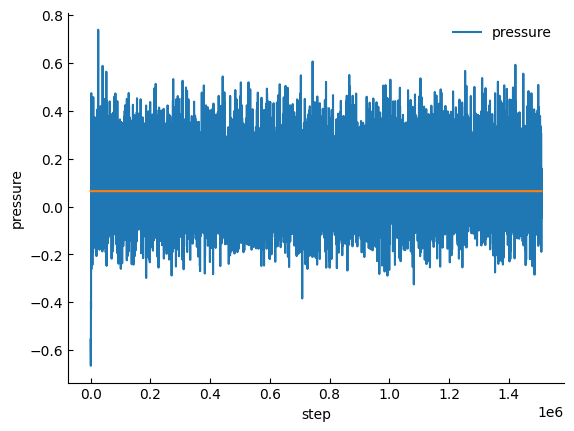

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


targetP = 0.064068

df = pd.read_csv("output-nvt-T1.1476-rho0.589.csv")

df.plot('step','pressure',xlabel='step',ylabel='pressure')
plt.plot(df['step'], np.ones_like(df['step'])*targetP)

The average pressure is slighlty above the target. Skipping early data, we can provide an estimate.

The MD pressure at density 0.589 is 0.10791764430753709


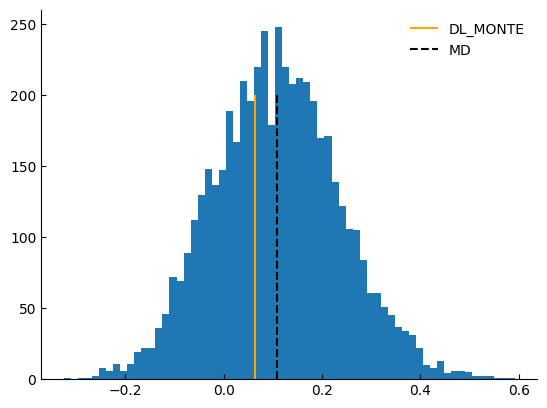

In [23]:
df['pressure'][10000:].hist(bins=64,grid=False)
plt.vlines(targetP,0,200, color='orange', label="DL_MONTE")
plt.vlines(df['pressure'][10000:].mean(),0,200, color='black', label="MD", linestyle="--")
plt.legend()
mdPressure = df['pressure'][10000:].mean()
print("The MD pressure at density 0.589 is",mdPressure)

## NPT run

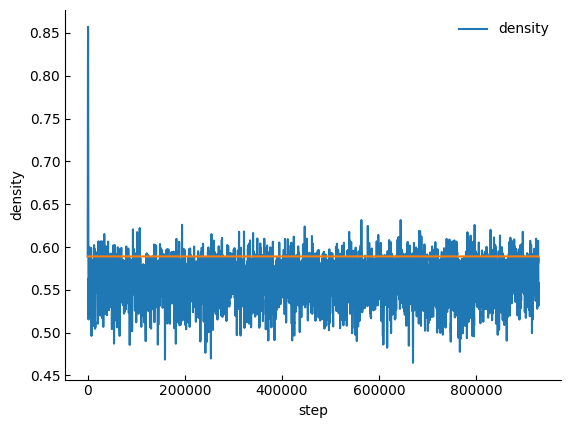

In [36]:
df_npt = pd.read_csv("output-npt-T1.1476-P0.064068.csv")
df_npt.plot('step','density', xlabel='step',ylabel='density',)
targetRho = 0.589
plt.plot(df_npt['step'], np.ones_like(df_npt['step'])*targetRho)

In [32]:
df_npt['density'][1000:].mean()

0.559313442810542

It seems that a slightly higher pressure is needed to get to the target density. The MD run, however, does not phase separate, so the liquid is still stable.

The disaggreement remains if I take larger simulations (1987 particles vs 589 for the plots above).

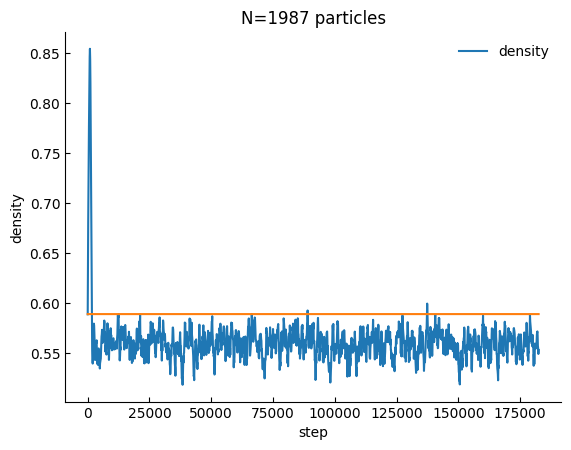

In [35]:
df_npt = pd.read_csv("output-npt-larger-T1.1476-P0.064068.csv")
df_npt.plot('step','density', xlabel='step',ylabel='density', title="N=1987 particles")
targetRho = 0.589
plt.plot(df_npt['step'], np.ones_like(df_npt['step'])*targetRho)
